In [1]:
# clears memory in case want to run script again with new threshold
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [ ]:
# first call bash script to get necessary file inputs
# for geographic script, choose query_samples for underway gps data alignment as input script
# for worms script, choose names_ids.csv for input script
subprocess.call(['./exec.sh'])

In [3]:
# read in level 1_b file
all_rois = pd.read_csv('file_1b.csv')
# prompt user to ask for desired size distribution, keep at 20 for now
threshold = input('Please enter minimum Major Axis Length to analyze (micrometers): ')
threshold = float(threshold)

Please enter minimum Major Axis Length to analyze (micrometers): 20


In [4]:
# read in gps coordinates file
coords = pd.read_csv('comparison.csv', usecols=['pid', 'gps_furuno_latitude', 'gps_furuno_longitude'])
# merge with all_rois based on smaple ids
all_rois = pd.merge(all_rois, coords, how='left', left_on='sample_identifier', right_on='pid')

In [5]:
# calculate total biovolume per sample
total = all_rois.groupby('sample_identifier')['Biovolume'].sum().reset_index()
total.rename(columns={'Biovolume':'total_biovolume'}, inplace=True)
# merge 2 data frames based on sample_identifier
all_rois = pd.merge(all_rois, total, how='left', on='sample_identifier')

In [6]:
# filter out rows below threshold
all_rois = all_rois[all_rois.MajorAxisLength > threshold]

In [7]:
# group by sample identifiers and higher ranks to calculate total biovolume per ranking
rois = all_rois.groupby(
    ['sample_identifier', 'resolved_higher_order_fromgnr']).agg(
    {
        'Biovolume': 'sum',
        'gps_furuno_latitude': 'first',
        'total_biovolume': 'first'
    }
).reset_index()
# calculate percent biovolume
rois['percent_biovolume'] = rois['Biovolume']/rois['total_biovolume']

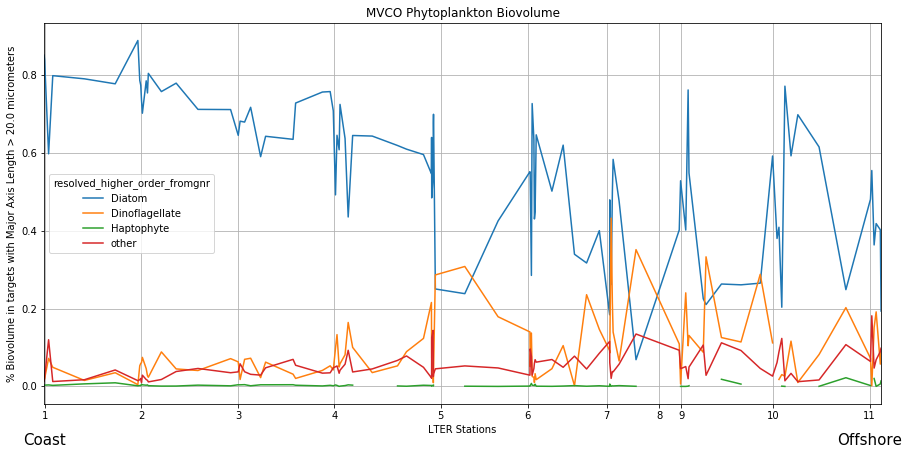

In [8]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
rois = rois.groupby(['gps_furuno_latitude','resolved_higher_order_fromgnr']).sum()['percent_biovolume']
rois.unstack().plot(ax=ax)
# add titles and axes labels
plt.xlabel('LTER Stations')
plt.ylabel('% Biovolume in targets with Major Axis Length > {} micrometers'.format(threshold))
plt.title('MVCO Phytoplankton Biovolume')
plt.grid(True)
# set stations as tick marks
ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
ax.set_xticklabels(np.arange(1,12))
# set comments
ax.text(41.1967, -0.15, "Coast", size = 15, ha = 'center')
ax.text(39.7733, -0.15, "Offshore", size = 15, ha = 'center')
# invert x axis
ax.invert_xaxis()
plt.show()